In [2]:
import tensorflow as tf
assert tf.__version__.startswith('2')

import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/Molo17/dataset.zip

In [5]:
base_dir = 'dataset'
base_dir = pathlib.Path(base_dir)
VALIDATION_SPLIT = 0.3
SEED = 100
BATCH_SIZE = 32
IMAGE_SIZE = 250

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    shuffle=True,
    seed=SEED,
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    shuffle=True,
    seed=SEED,
    subset='validation')

Found 2829 images belonging to 6 classes.
Found 1209 images belonging to 6 classes.


In [7]:
for image_batch, label_batch in train_generator:
    break
image_batch.shape, label_batch.shape

((32, 250, 250, 3), (32, 6))

In [8]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
    f.write(labels)

{'Capacitor': 0, 'Diode': 1, 'IC': 2, 'Inductor': 3, 'Resistor': 4, 'Transformer': 5}


In [9]:
!cat labels.txt

Capacitor
Diode
IC
Inductor
Resistor
Transformer

In [10]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [12]:
base_model.trainable = False

In [20]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=IMG_SHAPE),
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    base_model,
    #tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_1 (RandomFlip)   (None, 250, 250, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 250, 250, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
________________________________________

In [23]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 2


In [24]:
loss0, accuracy0 = model.evaluate(val_generator)

14/38 [==========>...................] - ETA: 35s - loss: 2.0562 - accuracy: 0.1395

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


38/38 [==============================] - 58s 1s/step - loss: 2.0526 - accuracy: 0.1589


In [25]:
initial_epochs = 10

history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=initial_epochs, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/10
89/89 [==============================] - ETA: 0s - loss: 1.7255 - accuracy: 0.3280

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


89/89 [==============================] - 200s 2s/step - loss: 1.7255 - accuracy: 0.3280 - val_loss: 1.4417 - val_accuracy: 0.4467
Epoch 2/10
89/89 [==============================] - 196s 2s/step - loss: 1.4227 - accuracy: 0.4595 - val_loss: 1.2612 - val_accuracy: 0.5327
Epoch 3/10
89/89 [==============================] - 196s 2s/step - loss: 1.2708 - accuracy: 0.5200 - val_loss: 1.1383 - val_accuracy: 0.6046
Epoch 4/10
89/89 [==============================] - 196s 2s/step - loss: 1.1715 - accuracy: 0.5688 - val_loss: 1.0562 - val_accuracy: 0.6261
Epoch 5/10
89/89 [==============================] - 195s 2s/step - loss: 1.0934 - accuracy: 0.5889 - val_loss: 0.9939 - val_accuracy: 0.6460
Epoch 6/10
89/89 [==============================] - 195s 2s/step - loss: 1.0401 - accuracy: 0.6214 - val_loss: 0.9497 - val_accuracy: 0.6700
Epoch 7/10
89/89 [==============================] - 195s 2s/step - loss: 0.9917 - accuracy: 0.6419 - val_loss: 0.9136 - val_accuracy: 0.6807
Epoch 8/10
89/89 [======

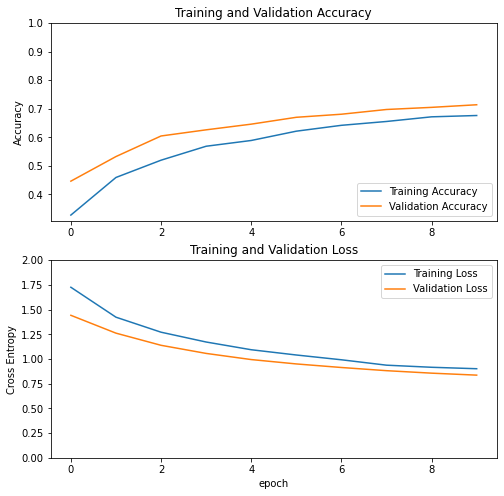

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


In [30]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_1 (RandomFlip)   (None, 250, 250, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 250, 250, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 1,869,126
Non-trainable params: 396,544
______________________________________

In [32]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 56


In [36]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=total_epochs, 
                         initial_epoch=history.epoch[-1],
                         validation_data=val_generator, 
                         validation_steps=len(val_generator))

Epoch 10/20
89/89 [==============================] - ETA: 0s - loss: 1.1826 - accuracy: 0.5616

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


89/89 [==============================] - 307s 3s/step - loss: 1.1817 - accuracy: 0.5619 - val_loss: 0.8137 - val_accuracy: 0.7213
Epoch 11/20
89/89 [==============================] - 301s 3s/step - loss: 0.9086 - accuracy: 0.6775 - val_loss: 0.7871 - val_accuracy: 0.7328
Epoch 12/20
89/89 [==============================] - 302s 3s/step - loss: 0.8252 - accuracy: 0.7128 - val_loss: 0.7644 - val_accuracy: 0.7345
Epoch 13/20
89/89 [==============================] - 305s 3s/step - loss: 0.7766 - accuracy: 0.7301 - val_loss: 0.7374 - val_accuracy: 0.7428
Epoch 14/20
89/89 [==============================] - 304s 3s/step - loss: 0.7269 - accuracy: 0.7518 - val_loss: 0.7150 - val_accuracy: 0.7477
Epoch 15/20
89/89 [==============================] - 304s 3s/step - loss: 0.6937 - accuracy: 0.7587 - val_loss: 0.6873 - val_accuracy: 0.7552
Epoch 16/20
89/89 [==============================] - 303s 3s/step - loss: 0.6572 - accuracy: 0.7781 - val_loss: 0.6694 - val_accuracy: 0.7618
Epoch 17/20
89/89 

In [37]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('mobilenet_v2_fine_tuned2.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: save/fine_tuning/assets


In [38]:
from google.colab import files

files.download('mobilenet_v2_fine_tuned2.tflite')
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

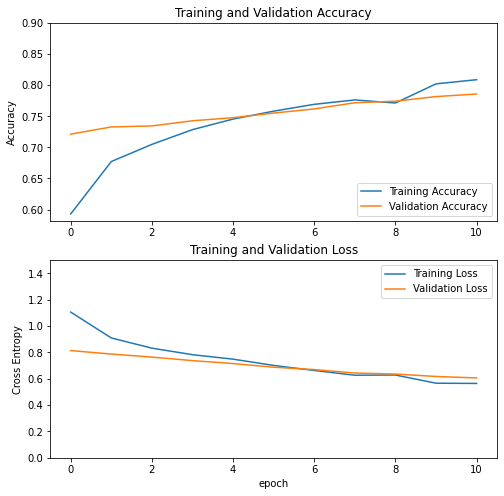

In [42]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.9])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()